This notebook shows how to evaluate the F1 scores for a particular field. First, select four 256X256 pixel sub-fields for evaluation and record their coordinates. Next, create ground truth annotations of nuclei in GIMP for these four sub-fields. Try to get two sparse and two densely-packed regions of nuclei. Next, perform nuclear segmentation using various platforms and produce binary masks for evaluation and store all these in a folder with the filenames being the name of the platform. Run this notebook to get the F1 scores for each of the evaluation subfields. Run separate notebooks for each different field/WSI you are creating ground truth annotations/
evaluating. This notebooks allows for qualitative evaluation in the form of platform binary masks overlayed on ground truth masks for comparison as well quantitative evaluation in the form of F1-scores at various IoU thresholds.

After running a similar notebook for multiple fields of a dataset, use the all_fields.ipynb notebook to combine the data to quantitatively compare the nuclear segmentation performance of the platforms across all the fields sampled from a dataset. This should give an idea of the relative performances of the platforms across the entire dataset for nuclear segmentation.

In [1]:
import os
import skimage.io as io
import pandas as pd
import numpy as np
import skimage.morphology
import skimage.segmentation
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff as hausdorff
from scipy import stats
import sigfig
import seaborn as sns
from evaluation import accuracy_calculator
from evaluation import intersection_over_union
from evaluation import F1_score_calculator
sns.set_style("whitegrid")

In [2]:
# Change these filepaths to access files on a local machine

# Path to save the csv file contaning the platform F1-scores for each subfield at 0.5 IoU
F1_5IoU_csv_path = '/Users/abishek/Desktop/MRL/Platforms/code/nuclear_seg/F1_5IoU_csv/test/TME11.csv'
# Path to save the bar plot contaning the platform F1-scores at 0.5 IoU
F1_5IoU_plot_path = '/Users/abishek/Desktop/MRL/Platforms/code/nuclear_seg/F1_5IoU_plot/test/TME11.png'
# Path to save the csv file contaning the platform F1-scores for each subfield at a range of IoUs
F1_allIoU_csv_path = '/Users/abishek/Desktop/MRL/Platforms/code/nuclear_seg/F1_allIoU_csv/test/TME11.csv'
# Path to save the line plot contaning the platform F1-scores at a range of IoUs
F1_allIoU_plot_path = '/Users/abishek/Desktop/MRL/Platforms/code/nuclear_seg/F1_allIoU_plot/test/TME11.png'

# Path to the directory containing the binary masks of the whole field from each platform
platforms_dir_path = '/Users/abishek/Desktop/MRL/Platforms/Code/Fields/TME11_12154_44141/Platforms'

# Path to the directory the four ground truth sub fields
gr_tr_dir_path = '/Users/abishek/Desktop/MRL/Platforms/Code/Fields/TME11_12154_44141/ground_truth'

# Coordinates of the top-left corener of the four subfields, with the dictionary keys being the names of the
# subfields
coordinate_dict = {'sparse1': (0, 1378),'dense1': (434, 691), 'sparse2': (1092, 231), 'dense2': (704, 939)}

# Path to save overlayed images (platform masks on ground truth) for qualitative evaluation of segmentation
eval_images_path = '/Users/abishek/Desktop/MRL/Platforms/code/nuclear_seg/eval_images/TME11'

In [3]:
# Reading the ground truth binary masks into arrays. Make sure that the ground truth binary masks are named
# according to the file name shown below
gr_tr_sparse1 = io.imread(os.path.join(gr_tr_dir_path, 'gr_tr_sparse1.tiff'))
gr_tr_sparse2 = io.imread(os.path.join(gr_tr_dir_path, 'gr_tr_sparse2.tiff'))
gr_tr_dense1 = io.imread(os.path.join(gr_tr_dir_path, 'gr_tr_dense1.tiff'))
gr_tr_dense2 = io.imread(os.path.join(gr_tr_dir_path, 'gr_tr_dense2.tiff'))
# Dictionary with keys being the string containing the name of the subfield and the values being the ground 
# truth arrays
gr_tr_mask_dict = {'sparse1': gr_tr_sparse1, 'sparse2': gr_tr_sparse2, 'dense1': gr_tr_dense1,
                   'dense2': gr_tr_dense2}

The below code is used to generate a dataframe where the columns are the platforms being implemented and the rows are the F1 scores for each evaluation subfield at 0.5 intersection over union (IoU) threshold. This means that a predicted nucleus has to have at least 0.5 IoU to be counted as a true positive. Having an IoU of 0.5 or above ensures that there is a maximum of one true positive predicted nucleus for every ground truth nucleus. The code is also used to generate the overlays of platform nuclei masks on ground truth nuclei masks for qualitative evaluation.

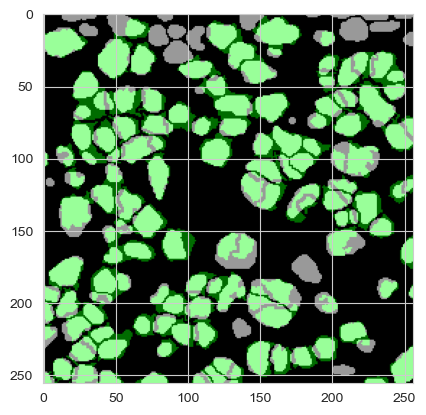

ilastik_sparse1
TP:53, FP:44, FN:85, ground truth nuclei:138
F1-score:0.4510638297853146


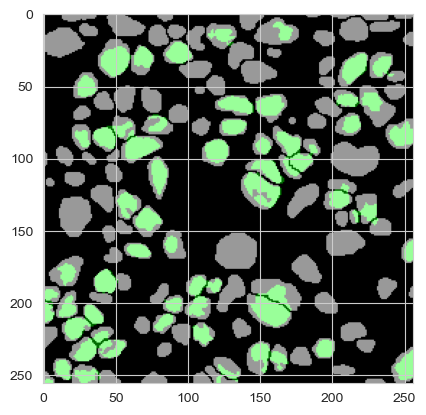

CellProfiler_sparse1
TP:32, FP:18, FN:106, ground truth nuclei:138
F1-score:0.34042553191308284


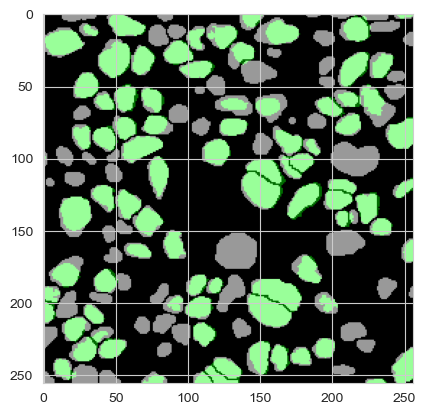

CellPose_sparse1
TP:68, FP:9, FN:70, ground truth nuclei:138
F1-score:0.6325581395319416


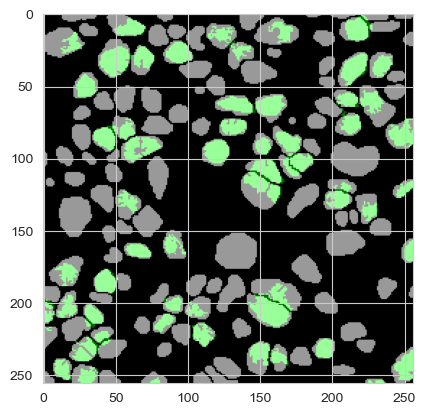

Fiji_sparse1
TP:33, FP:27, FN:105, ground truth nuclei:138
F1-score:0.33333333333164983


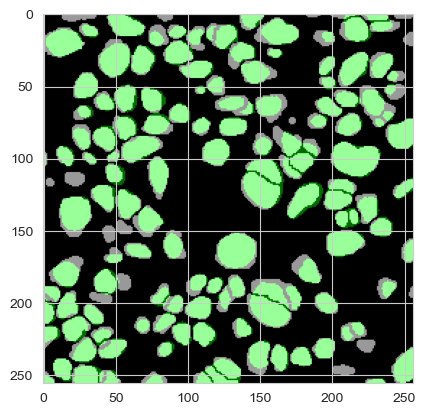

StarDist_sparse1
TP:99, FP:23, FN:39, ground truth nuclei:138
F1-score:0.7615384615355326


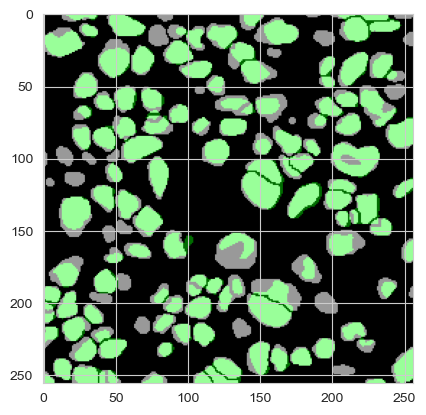

InForm_sparse1
TP:82, FP:20, FN:56, ground truth nuclei:138
F1-score:0.6833333333304862


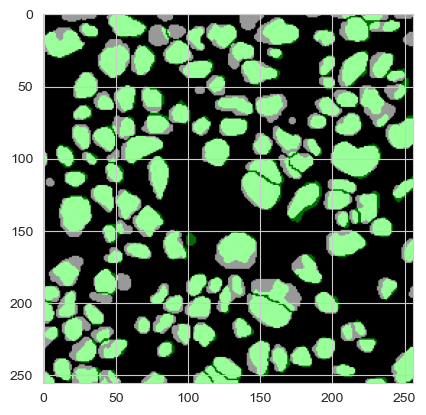

QuPath_sparse1
TP:100, FP:20, FN:38, ground truth nuclei:138
F1-score:0.7751937984466079


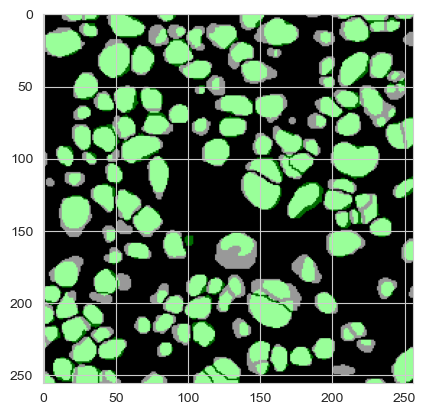

Mesmer_sparse1
TP:95, FP:45, FN:43, ground truth nuclei:138
F1-score:0.6834532374076135


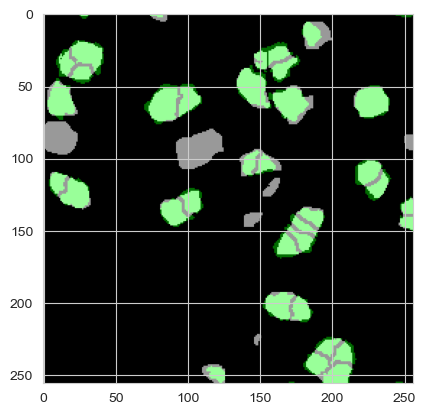

ilastik_sparse2
TP:8, FP:31, FN:18, ground truth nuclei:26
F1-score:0.24615384615005917


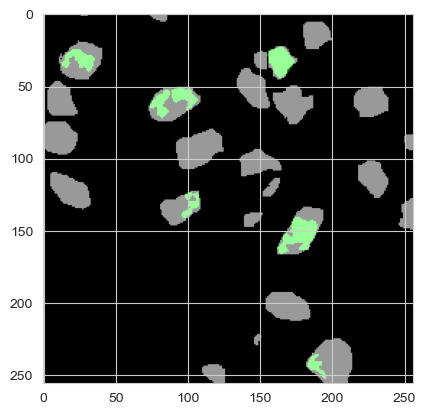

CellProfiler_sparse2
TP:2, FP:6, FN:24, ground truth nuclei:26
F1-score:0.11764705882006922


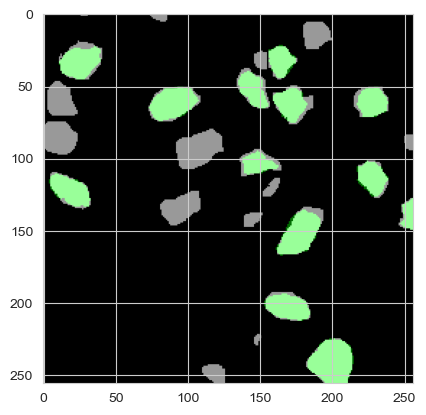

CellPose_sparse2
TP:13, FP:2, FN:13, ground truth nuclei:26
F1-score:0.6341463414479477


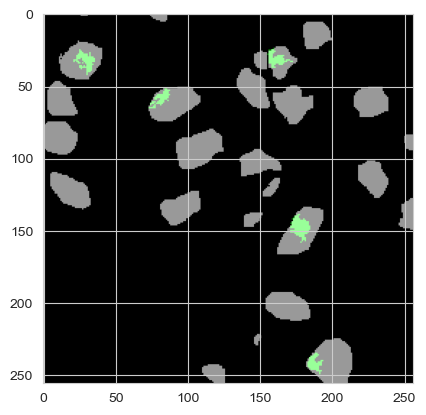

Fiji_sparse2
TP:0, FP:6, FN:26, ground truth nuclei:26
F1-score:0.0


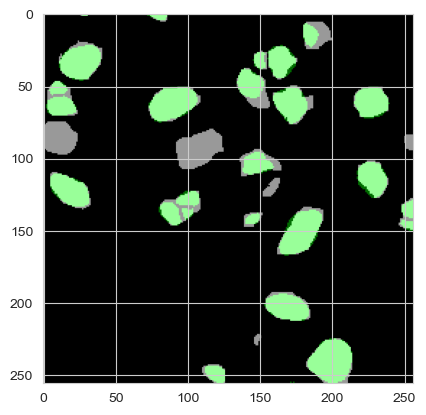

StarDist_sparse2
TP:19, FP:10, FN:7, ground truth nuclei:26
F1-score:0.690909090896529


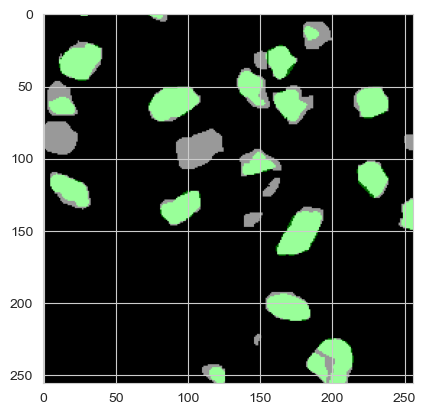

InForm_sparse2
TP:16, FP:5, FN:10, ground truth nuclei:26
F1-score:0.6808510638153011


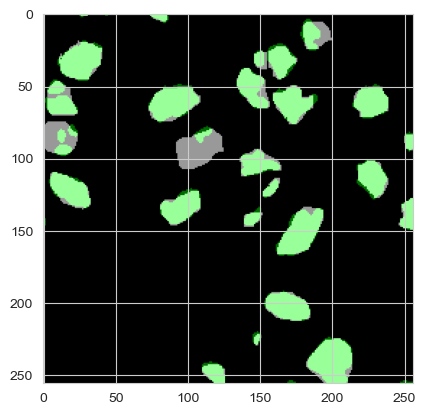

QuPath_sparse2
TP:23, FP:11, FN:3, ground truth nuclei:26
F1-score:0.7666666666538889


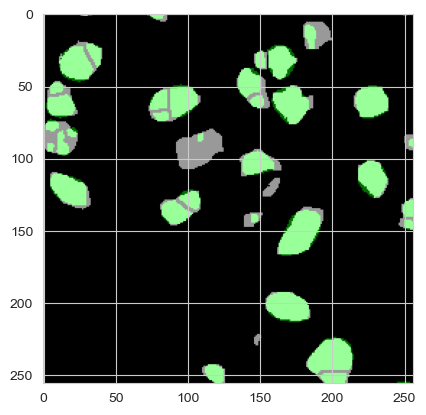

Mesmer_sparse2
TP:16, FP:22, FN:10, ground truth nuclei:26
F1-score:0.49999999999218747


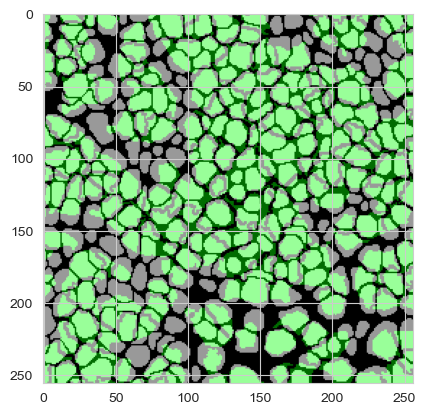

ilastik_dense1
TP:38, FP:117, FN:267, ground truth nuclei:305
F1-score:0.16521739130398866


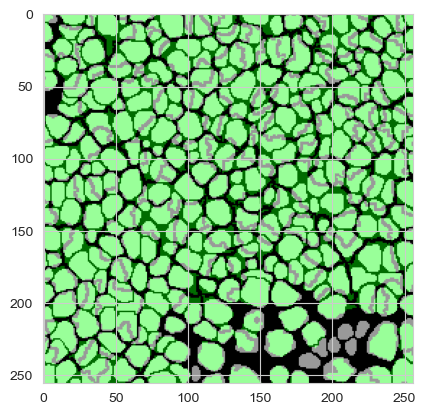

CellProfiler_dense1
TP:60, FP:115, FN:245, ground truth nuclei:305
F1-score:0.24999999999947917


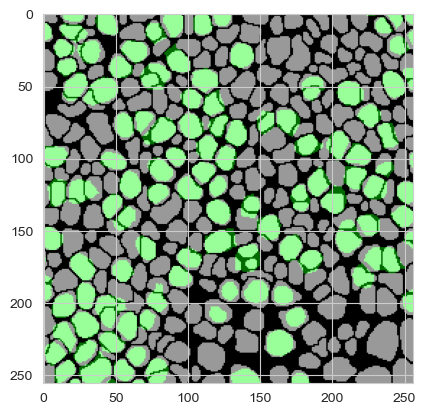

CellPose_dense1
TP:86, FP:33, FN:219, ground truth nuclei:305
F1-score:0.40566037735753385


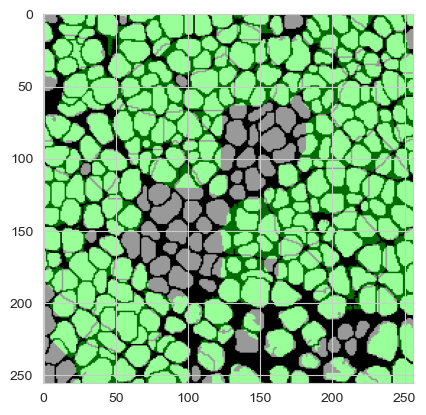

Fiji_dense1
TP:58, FP:64, FN:247, ground truth nuclei:305
F1-score:0.27166276346540597


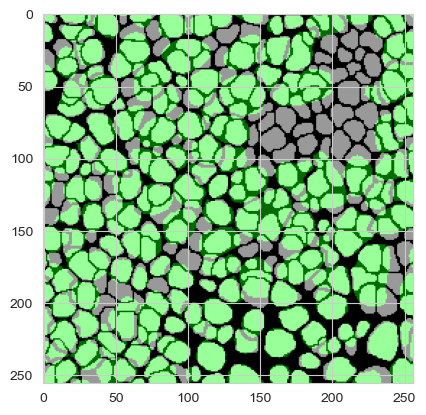

StarDist_dense1
TP:77, FP:75, FN:228, ground truth nuclei:305
F1-score:0.33698030634499565


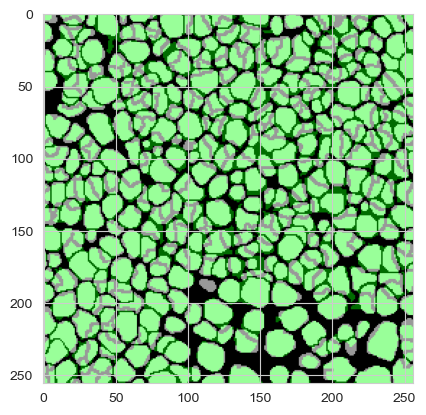

InForm_dense1
TP:99, FP:203, FN:206, ground truth nuclei:305
F1-score:0.32619439868150546


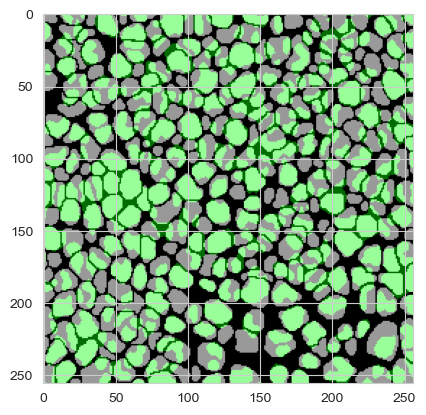

QuPath_dense1
TP:69, FP:149, FN:236, ground truth nuclei:305
F1-score:0.2638623326954802


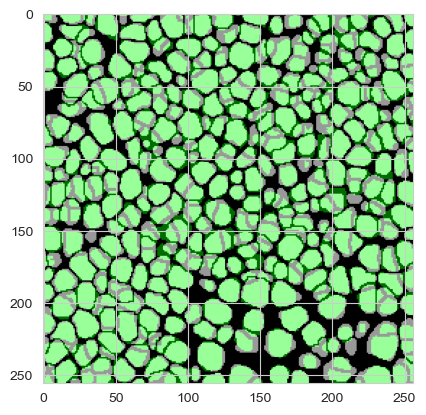

Mesmer_dense1
TP:155, FP:166, FN:150, ground truth nuclei:305
F1-score:0.49520766773083835


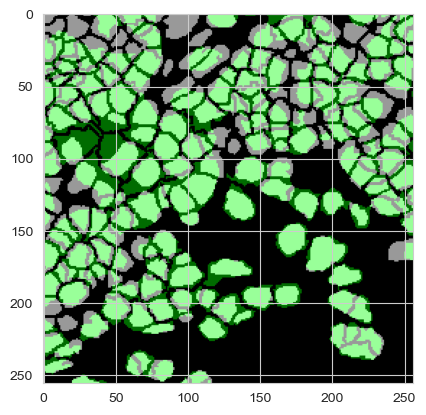

ilastik_dense2
TP:40, FP:91, FN:141, ground truth nuclei:181
F1-score:0.2564102564094346


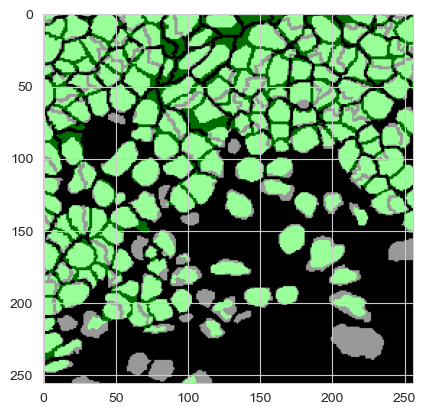

CellProfiler_dense2
TP:53, FP:65, FN:128, ground truth nuclei:181
F1-score:0.3545150501660384


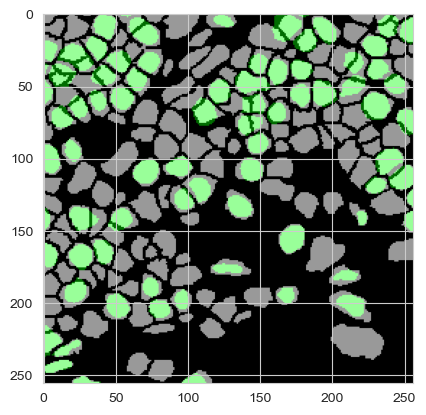

CellPose_dense2
TP:61, FP:17, FN:120, ground truth nuclei:181
F1-score:0.4710424710406524


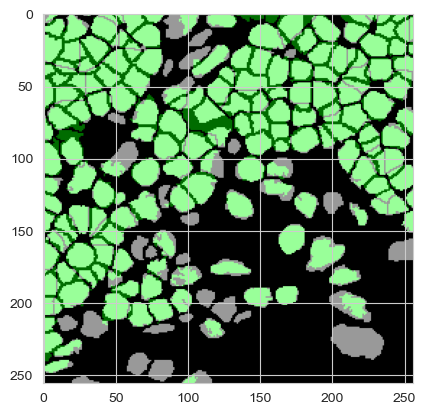

Fiji_dense2
TP:65, FP:47, FN:116, ground truth nuclei:181
F1-score:0.4436860068244243


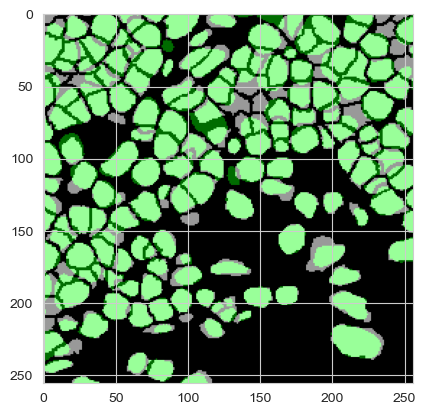

StarDist_dense2
TP:101, FP:37, FN:80, ground truth nuclei:181
F1-score:0.6332288401234069


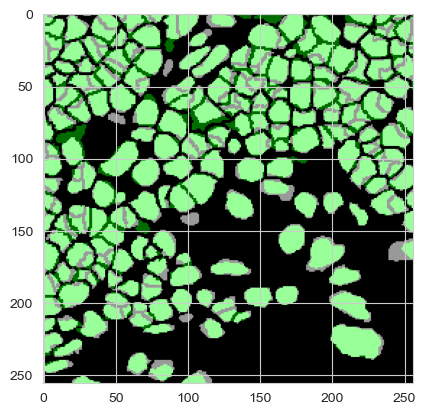

InForm_dense2
TP:100, FP:96, FN:81, ground truth nuclei:181
F1-score:0.5305039787784337


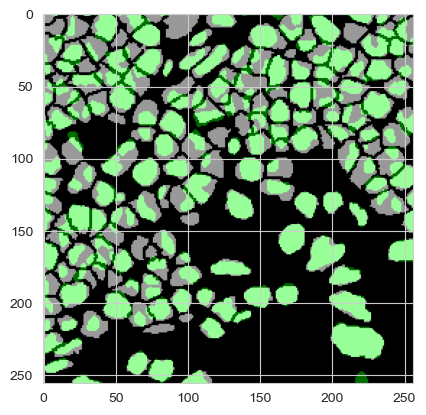

QuPath_dense2
TP:63, FP:93, FN:118, ground truth nuclei:181
F1-score:0.3738872403549736


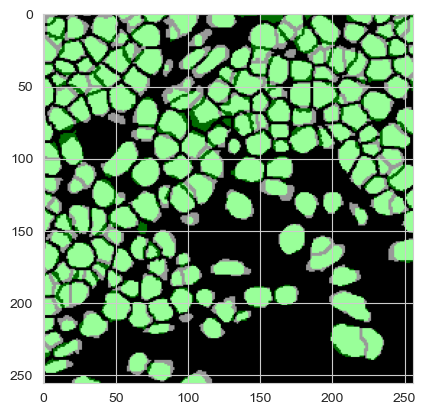

Mesmer_dense2
TP:141, FP:60, FN:40, ground truth nuclei:181
F1-score:0.7382198952860256


In [4]:
# this dictionary will be populated with subfield names and their associated F1 scores for each platform. Alter
# the keys of the dictionary to include the platforms being implemented
df_dict_F1 = {'subfield': [], 'ilastik': [], 'CellProfiler': [], 'Fiji': [], 'QuPath': [],
                            'Mesmer': [], 'InForm': [], 'CellPose': [], 'StarDist': []}
# initializing the ground truth nuclei count to be incremented
gr_tr_nuclei_count = []
# iterating over all 4 subfields
for subfield in gr_tr_mask_dict.keys():
    # iterating over each platform's binary mask
    for img in os.listdir(platforms_dir_path):
        # processes only tiff files
        if img[-5:]=='.tiff' or img[-4:]=='.tif':
            platform_whole_img = io.imread(os.path.join(platforms_dir_path, img))
            platform = img[:img.find('.')]
            # adds a new entry in the dictionary for the subfield if it is not already added
            if subfield not in df_dict_F1['subfield']:
                df_dict_F1['subfield'].append(subfield)
            else:
                pass
            # gets the ground truth mask for the current subfield
            gr_tr_img = gr_tr_mask_dict[subfield]
            # gets the coordinates for the current subfield
            top_left_row = coordinate_dict[subfield][0]
            top_left_column = coordinate_dict[subfield][1]
            # crops the platform binary mask to isolate the region to be evaluated
            platform_img = platform_whole_img[top_left_row:top_left_row+256, top_left_column:top_left_column+256]
            # creating a ground truth binary mask for visualization purposes in white and black
            gr_tr_img_show = np.uint8(np.zeros((gr_tr_img.shape[0], gr_tr_img.shape[1], 3)))
            gr_tr_img_show[gr_tr_img == 255] = [255, 255, 255]
            # creating a ground truth binary mask for visualization purposes in green and black
            platform_img_show = np.uint8(np.zeros((platform_img.shape[0], platform_img.shape[1], 3)))
            platform_img_show[platform_img == 255] = [0, 120, 0]
            # overlaying the platform over the ground truth binary mask
            dst = cv2.addWeighted(gr_tr_img_show, 0.6, platform_img_show, 0.9, 0)
            # for visualization in the notebook
            plt.imshow(dst)
            plt.show()
            # to save the overlayed images for qualitative evaluation
            io.imsave(os.path.join(eval_images_path, platform + '_' + subfield + '.tiff'), dst)

            print(platform + '_' + subfield)
            accuracy = accuracy_calculator(platform_img, gr_tr_img)
            # calculating the F1-score of the current platform subfield
            F1, nuclei_count, cur_gr_tr_nuclei_count, aHD = F1_score_calculator(platform_img, gr_tr_img, 0.5)
            # Adding the F1-score to the F1-score dictionary
            df_dict_F1[platform].append(F1)
        else:
            pass
    # updating the ground truth nuclei count for the current subfield    
    gr_tr_nuclei_count.append(cur_gr_tr_nuclei_count)
# Adding up the ground truth nuclei in all the subfields
gr_tr_nuclei_count = sum(gr_tr_nuclei_count)

# Converting the F1-score dictionary to a dataframe
df_F1 = pd.DataFrame(df_dict_F1)
# Setting the index to be the subfield name
df_F1 = df_F1.set_index('subfield')

In [5]:
print(f'{gr_tr_nuclei_count} ground truth nuclei have been segmented.')

650 ground truth nuclei have been segmented.


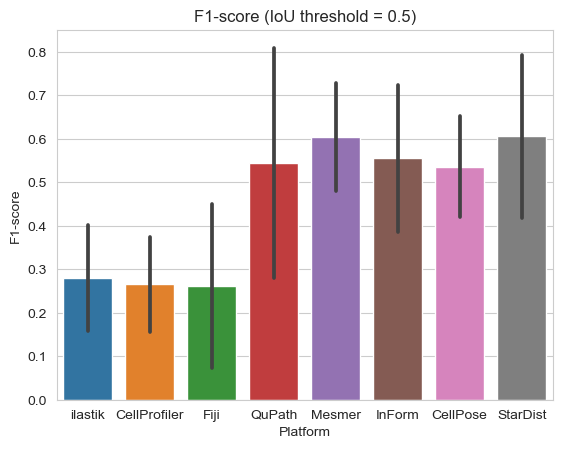

In [6]:
# Creating a barplot with errorbars being one standard deviation
F1_barplot = sns.barplot(data=df_F1, errorbar='sd')
F1_barplot.set(xlabel ="Platform", ylabel = "F1-score", title ='F1-score (IoU threshold = 0.5)')
# saving this figure
plt.savefig(F1_5IoU_plot_path, dpi=500)

In [7]:
# converting the dataframe with the F1-scores at 0.5 IoU to a csv file
df_F1.to_csv(F1_5IoU_csv_path)

The below block of code is used to generate a dataframe where the columns are platforms to be evaluated and the rows are the average F1-scores over the 4 subfields at various IoU thresholds (rows correspond to IoU thresholds).

In [8]:
# Initializing the dictionary which will contain the F1-scores (averaged over 4 subfields)
df_mean_dict = {}
df_mean = pd.DataFrame(df_mean_dict)

# Iterating for various IoU thresholds
for IoU_thresh in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:

    # this dictionary will be populated with IoU thresholds and their associated mean F1 scores for each platform.
    # Alter the keys of the dictionary to include the platforms being implemented
    df_dict_F1 = {'subfield': [], 'ilastik': [], 'CellProfiler': [], 'Fiji': [], 'QuPath': [],
                                'Mesmer': [], 'InForm': [], 'CellPose': [], 'StarDist': []}

    # iterating over all 4 subfields
    for subfield in gr_tr_mask_dict.keys():
        # iterating over each platform's binary mask
        for img in os.listdir(platforms_dir_path):
            # only processed tiff files
            if img[-5:]=='.tiff' or img[-4:]=='.tif':
                platform_whole_img = io.imread(os.path.join(platforms_dir_path, img))
                platform = img[:img.find('.')]
                # adds a new entry in the dictionary for the subfield if it is not already added
                if subfield not in df_dict_F1['subfield']:
                    df_dict_F1['subfield'].append(subfield)
                else:
                    pass
                # gets the ground truth mask for the current subfield
                gr_tr_img = gr_tr_mask_dict[subfield]
                # gets the coordinates for the current subfield
                top_left_row = coordinate_dict[subfield][0]
                top_left_column = coordinate_dict[subfield][1]
                # crops the platform binary mask to isolate the region to be evaluated
                platform_img = platform_whole_img[top_left_row:top_left_row+256,
                                                  top_left_column:top_left_column+256]

                accuracy = accuracy_calculator(platform_img, gr_tr_img)
                # calculating the F1-score of the current platform subfield at the current IoU threshold
                F1, nuclei_count, cur_gr_tr_nuclei_count, aHD = F1_score_calculator(platform_img, gr_tr_img,
                                                                                    IoU_thresh, printing=False)
                # Adding the F1-score to the F1-score dictionary
                df_dict_F1[platform].append(F1)
            else:
                pass
    # Converting the F1-score dictionary to a dataframe
    df_F1 = pd.DataFrame(df_dict_F1)
    # Setting the index to be the subfield name
    df_F1 = df_F1.set_index('subfield')

    # Calculating the mean F1-score over the 4 subfields for each IoU threshold
    df_mean[str(IoU_thresh)] = df_F1.mean()

/var/folders/tb/t9xd8_k12c79sjm8cjqmr_x80000gn/T/ipykernel_35738/4148514152.py:2: UserWarning: 
The markers list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  mean_F1_barplot = sns.lineplot(data=df_mean_transpose, dashes=False, markers='s', legend=True)


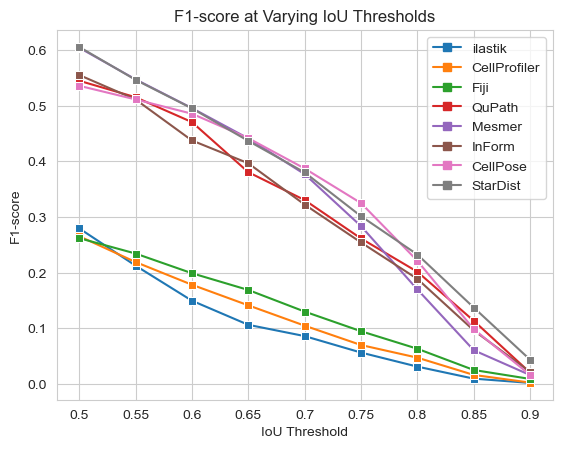

In [9]:
df_mean_transpose = df_mean.transpose()
mean_F1_barplot = sns.lineplot(data=df_mean_transpose, dashes=False, markers='s', legend=True)
mean_F1_barplot.set(xlabel ="IoU Threshold", ylabel = "F1-score", title ='F1-score at Varying IoU Thresholds')
plt.savefig(F1_allIoU_plot_path, dpi=500)